# **Incremental Forecast generation with MLForecast**

This article provides a practical framework for developing **incremental forecasting systems** using Nixtla’s `MLForecast`. It walks through the full process of building scalable time series pipelines-from baseline model training to monthly incremental updates-illustrating how `update()` enables efficient, real-time forecast refreshes without full retraining. The focus is on designing **sustainable, production-grade forecasting workflows** that balance speed, adaptability, and long-term accuracy.


## **Table of Contents**

1. [Introduction](#introduction)  
2. [Why You Shouldn’t Retrain Every Time](#why-you-shouldnt-retrain-every-time)  
3. [When to Retrain Anyway](#when-to-retrain-anyway)  
4. [A Hybrid Cadence for Sustainable Forecasting](#a-hybrid-cadence-for-sustainable-forecasting)  
5. [Code Implementation Overview](#code-implementation-overview)



## **Introduction**

When a forecasting system goes live, the flow of data doesn’t stop. Each month - or even each week - new observations arrive, and decision-makers expect your forecasts to adjust in real time. Yet, retraining the entire model every time new data comes in is often the default reaction. It seems simple, but it’s computationally expensive, time-consuming, and can introduce instability into production workflows.

This is where incremental forecasting becomes essential. Instead of retraining from scratch, we can incrementally update the model to reflect the latest data while preserving its learned patterns and parameters. In Nixtla’s `MLForecast`, the `update()` method provides this capability by allowing a trained forecasting object to absorb new observations without retraining the underlying estimator. It extends the historical window for each series, recalculates lag and date features, and ensures that subsequent forecasts are generated using the most recent actuals.

## **Why You Shouldn’t Retrain Every Time**

Once your forecasting system is operational, new data becomes a constant. Each cycle - be it daily, weekly, or monthly - brings new observations that reflect the latest market conditions. The instinctive reaction is to retrain the entire model whenever new data arrives, under the assumption that a fresh model guarantees higher accuracy. In practice, however, **frequent retraining is neither efficient nor necessary**.

Retraining a global model across thousands of time series is computationally expensive and can introduce instability into production pipelines. Each retrain recalculates lag features, re-splits data, re-fits hyperparameters, and may slightly shift model weights due to stochastic effects, creating subtle variations in forecast outputs that can confuse downstream systems or decision-makers. Moreover, most new observations tend to reinforce existing patterns rather than alter them drastically.

The **incremental update** approach offers a more robust alternative. Instead of discarding the existing model, MLForecast’s `update()` method allows you to append new observations to the existing historical window. It recalculates lag, lag_transforms, and date features while keeping the learned model parameters fixed. This ensures that your forecasts stay aligned with the most recent actuals without triggering a full retraining cycle.


## **When to Retrain Anyway**

Incremental updates are powerful, but they are not a permanent substitute for model retraining. Over time, even the most robust forecasting systems experience **concept drift** - subtle or abrupt changes in the underlying data-generating process. When this happens, the relationships your model once learned no longer represent reality. In other words, the past stops being a reliable guide to the future.

Retraining becomes necessary when the environment changes in ways that cannot be captured by simply appending new observations. Some common triggers include:

#### 1. Structural breaks in the data

Events such as product rebranding, changes in packaging, or shifts in demand patterns can cause discontinuities in historical trends. These “structural breaks” disrupt the temporal consistency that incremental updates rely on. A retraining cycle helps the model recalibrate to the new baseline.

#### 2. Distributional or seasonal drift

If the statistical properties of the series - mean, variance, or seasonal amplitudes - start deviating consistently from past patterns, your lag-based features become less predictive. Techniques like rolling RMSSE or residual analysis can help detect such drift.

#### 3. Changes in exogenous features

When the relationship between your target and external drivers (price, promotions, macroeconomic indicators, weather) changes, the model’s coefficients or learned patterns become outdated. Retraining allows it to relearn these dependencies.

#### 4. Model degradation in monitoring metrics

A steady rise in forecast error (e.g., RMSSE, MAPE, or WAPE) across multiple time series signals that incremental updates are no longer sufficient. This degradation can be tracked using an automated monitoring pipeline.

#### 5. Major business or market shifts

External shocks, like supply chain disruptions, policy changes, or demand surges, fundamentally alter temporal behavior. These events often invalidate learned relationships and require retraining to adapt.


## **A Hybrid Cadence for Sustainable Forecasting**


Retraining and updating are not competing strategies - they’re complementary. In a well-engineered forecasting pipeline, the two work together to balance **adaptability**, **efficiency**, and **stability**. This balanced cadence ensures your model evolves with data drift while avoiding unnecessary computational overhead.

A **hybrid cadence** combines three operational layers:

#### 1. Routine Incremental Updates (Short-Term Adaptation)

Use MLForecast’s `update()` method every time new data arrives - typically weekly or monthly.
This keeps forecasts current by recalculating lag and date features using the latest observations, without retraining the model.

* **Objective:** Maintain freshness of forecasts
* **Cost:** Minimal (light computation)
* **When to use:** After each data ingestion cycle

#### 2. Scheduled Retraining (Periodic Refresh)

Perform full model retraining at regular intervals - for instance, quarterly or semi-annually.
This refreshes feature relationships, captures gradual drift, and resets model parameters to reflect long-term trends.

* **Objective:** Recalibrate the model to evolving seasonal or macro patterns
* **Cost:** Moderate to high (training time and resource usage)
* **When to use:** On a fixed calendar schedule or after major seasonal transitions

#### 3. Drift-Triggered Retraining (Event-Based Correction)

Deploy monitoring scripts that track forecast accuracy (e.g., RMSSE, MAPE, WAPE) and detect statistical drift using tools such as the Kolmogorov–Smirnov test or rolling error windows.
If accuracy degrades beyond a defined threshold, initiate an unscheduled retrain.

* **Objective:** Respond to sudden or unanticipated changes
* **Cost:** High but justified by regained accuracy
* **When to use:** When metrics indicate model degradation or feature distribution shifts



#### Quantitative Validation

To evaluate the effectiveness of this cadence, compare update-only vs. retrain strategies using MLForecast’s `cross_validation()`:

* `refit=False` simulates incremental updates (trained once, updated continuously)
* `refit=True` simulates retraining at each historical window
  If `refit=True` consistently outperforms `refit=False`, it signals that drift is significant and retraining yields real gains.



#### Why It Works

This cadence prevents unnecessary full retrains, reduces downtime, and ensures forecasts remain both timely and accurate.
It mirrors the principles of **continuous learning** in machine learning systems -adapting efficiently without sacrificing stability.

In essence, **incremental updates keep your model agile; retraining keeps it honest.**


## **Code Implementation Overview**

#### **Installing `mlforecast` and Required Libraries**

Before we dive into incremental forecasting, let’s set up the environment by installing all necessary dependencies. |We’ll use **Nixtla’s `mlforecast`**, along with common Python libraries for data handling and visualization.

> 💡 *Tip:* If you’re running this in Google Colab or a fresh environment, it’s a good idea to restart the kernel after installation to ensure all dependencies are properly loaded.


In [1]:
!pip install mlforecast datasetsforecast s3fs -q

In [2]:
import xgboost as xgb
import pandas as pd
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from datasetsforecast.m3 import M3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

c:\Users\317379\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## **Loading the M3 Dataset**

For this demonstration, we’ll use the **M3 forecasting competition dataset**, a widely used benchmark for evaluating time series models.  
Specifically, we’ll focus on the **`M1` series** from the **Monthly (M) group**.

The M3 dataset provides multiple time series across different frequencies -*Yearly, Quarterly, Monthly, and Others*.  
By selecting one unique identifier (`unique_id = 'M1'`), we can visualize and test how incremental forecasting behaves on a single, interpretable time series.

> 📘 *Note:* The dataset is loaded using Nixtla’s `datasetsforecast` package, which automatically structures the data in the expected format for MLForecast - columns `unique_id`, `ds` (date), and `y` (target value).


In [3]:
# Load M3 data (e.g., monthly frequency)
Y_df, X_df, S_df = M3.load(directory='./', group='Monthly')

# Filter for the specified unique_id
select = ['M1']
df_select = Y_df[Y_df['unique_id'].isin(select)].copy()


# Convert 'Date' column to datetime in the original filtered dataframe
df_select['ds'] = pd.to_datetime(df_select['ds'])

# Sort by unique_id and Date to ensure correct slicing
df_select = df_select.sort_values(by=['unique_id', 'ds']).reset_index(drop=True)

# Display the first few records
df_select.head()

,unique_id,ds,y
0,M1,1990-01-31,2640.0
1,M1,1990-02-28,2640.0
2,M1,1990-03-31,2160.0
3,M1,1990-04-30,4200.0
4,M1,1990-05-31,3360.0


#### **Defining the Simulation Scenario**

To replicate a **real-world production forecasting setup**, we’ll simulate how forecasts evolve as new data arrives over time, without retraining the model. This helps us understand how Nixtla’s `update()` method can efficiently keep forecasts current in a live environment.

We’ll focus on the **last 39 observations** of our selected series, covering the period **from 1992-06-30 to 1995-08-31**.  
This range represents the tail end of a long historical time series, typical of what a production system might encounter.

Here’s how we’ll structure the simulation:

- Data **up to 1995-05-31** serves as the **baseline training period (Month 0)** - the last available data before the model is deployed.
- We then simulate **three consecutive production updates**, where new observations gradually arrive:
  - **Month 1:** Includes actuals for  *1995-06-30*  
  - **Month 2:** Includes actuals for *1995-07-31*  
  - **Month 3:** Includes actuals for *1995-08-31*  

At each step, the model will be **incrementally updated** using the `update()` method, allowing it to absorb new observations, recompute lags and date features, and produce refreshed forecasts without undergoing a full retraining cycle.



In [4]:
# Select the last 39 data points from df_select
last_39_points = df_select.tail(39).copy()

# From these 39 points:
# - Use the first 36 data points for initial model training (Month 0)
# - Reserve the last 3 data points as sequential "new data arrivals"
df_train = last_39_points.head(36).copy()
new_data_all = last_39_points.iloc[36:39].copy()

# Split the 3 new months into separate DataFrames to simulate data arriving one month at a time
new_data_month_one = new_data_all.iloc[0:1].copy()
new_data_month_two = new_data_all.iloc[1:2].copy()
new_data_month_three = new_data_all.iloc[2:3].copy()

print("Train DataFrame (last 39 points, first 36 for training):")
display(df_train.head())

print("\nNew Data Month One:")
display(new_data_month_one)

print("\nNew Data Month Two:")
display(new_data_month_two)

print("\nNew Data Month Three:")
display(new_data_month_three)

Train DataFrame (last 39 points, first 36 for training):


,unique_id,ds,y
29,M1,1992-06-30,4080.0
30,M1,1992-07-31,5880.0
31,M1,1992-08-31,1680.0
32,M1,1992-09-30,6720.0
33,M1,1992-10-31,2040.0



New Data Month One:


,unique_id,ds,y
65,M1,1995-06-30,480.0



New Data Month Two:


,unique_id,ds,y
66,M1,1995-07-31,2040.0



New Data Month Three:


,unique_id,ds,y
67,M1,1995-08-31,1440.0


#### **Model specification - XGBoost with lags and lag_transforms**

For this demonstration we use XGBoost Regressor together with a small set of lag features and lag_transforms. The goal is to keep the model simple and interpretable while preserving enough temporal information to produce reliable incremental forecasts.

In [5]:
# Load your data (must have columns: unique_id, ds, y)
df = df_train.copy()

# Initialize MLForecast with an XGBoost regressor
# Parameters:
#   models         : regression algorithm(s) to use
#   freq           : data frequency ('ME' = month-end)
#   lags           : how many past time steps to use as predictors
#   lag_transforms : statistical transforms (rolling/expanding means)
#   date_features  : calendar features automatically derived from 'ds'
# The combination of lags + transforms helps the model capture both short-term dependencies and smoothed seasonal effects.
fcst = MLForecast(
    models=xgb.XGBRegressor(verbosity=0, random_state=5),
    freq='ME',  
    lags=[1, 3, 6],  
    lag_transforms={
        1: [ExpandingMean()], 
        3: [RollingMean(window_size=3), RollingMean(window_size=6)]
    },
    date_features=['month', 'quarter', 'year']
)

# Fit the baseline model (Month 0)
# This trains the model using historical data up to 1995-05-31. 
# The fitted object stores the trained regressor and all feature transformations.
fcst.fit(df)

# Generate baseline forecasts (e.g., 12 months ahead)
# 'h' defines the forecast horizon (number of steps ahead).
# At this stage, forecasts are produced using data available up to Month 0.
predictions_month_zero = fcst.predict(h=12)

# Display the baseline predictions for review
print("\nPredictions at Month Zero:")
display(predictions_month_zero)


Predictions at Month Zero:


,unique_id,ds,XGBRegressor
0,M1,1995-06-30,3570.747803
1,M1,1995-07-31,3519.310059
2,M1,1995-08-31,2348.593506
3,M1,1995-09-30,3084.184814
4,M1,1995-10-31,3304.192627
5,M1,1995-11-30,2952.502686
6,M1,1995-12-31,4652.264648
7,M1,1996-01-31,3011.031494
8,M1,1996-02-29,3310.872803
9,M1,1996-03-31,3070.798340


#### Updating the Model for Month One

Now that we have the actuals for **Month One (June 1995)**, we’ll simulate how a forecasting system incorporates this new data without retraining.  

Instead of rebuilding the model from scratch, we’ll use the `update()` method to **incrementally refresh** the forecasting object.  
This operation allows the model to:

- Absorb the latest observation into its internal history  
- Recompute lag and date-based features  
- Generate forecasts that reflect the most recent trend  

Importantly, the underlying model parameters remain fixed, we are simply extending the historical window that the model bases its predictions on. This is the essence of *incremental forecasting*: fast, efficient, and adaptive to streaming data.


In [6]:
# Update the trained model with the latest observation
fcst.update(new_data_month_one)

# Produce a new 12-month-ahead forecast using the extended data window.
predictions_month_one = fcst.predict(h=12)

# Display the updated predictions
print("\nPredictions at Month One:")
display(predictions_month_one)


Predictions at Month One:


,unique_id,ds,XGBRegressor
0,M1,1995-07-31,3877.634277
1,M1,1995-08-31,2946.929443
2,M1,1995-09-30,4335.560547
3,M1,1995-10-31,3431.002197
4,M1,1995-11-30,3319.986084
5,M1,1995-12-31,4944.199219
6,M1,1996-01-31,3011.031494
7,M1,1996-02-29,3385.225586
8,M1,1996-03-31,3083.476074
9,M1,1996-04-30,3282.901123


#### Updating the Model for Month Two

Next, we simulate the arrival of **Month Two (July 1995)** data. By this point, our model has already been incrementally updated with the June actuals. Now, we extend the historical window once more by incorporating the July observation.

In [7]:
# Update the forecasting object with the July 1995 data
fcst.update(new_data_month_two)

# Generate new forecasts (12 months ahead) after Month Two update
predictions_month_two = fcst.predict(h=12)

# Display the updated forecasts for Month Two
print("\nPredictions at Month Two:")
display(predictions_month_two)


Predictions at Month Two:


,unique_id,ds,XGBRegressor
0,M1,1995-08-31,3303.371094
1,M1,1995-09-30,4334.119629
2,M1,1995-10-31,997.796814
3,M1,1995-11-30,3892.199707
4,M1,1995-12-31,4634.063477
5,M1,1996-01-31,2115.614258
6,M1,1996-02-29,2832.536377
7,M1,1996-03-31,3122.120361
8,M1,1996-04-30,2420.745361
9,M1,1996-05-31,3265.199463


#### **Updating the Model for Month Three**

Finally, we simulate the arrival of **Month Three (August 1995)** actuals. By this stage, the model has already incorporated data from June and July through successive incremental updates. Now, we’ll perform one more `update()` to include the August observation.


In [8]:
# Update the model with Month Three data
fcst.update(new_data_month_three)

# Generate forecasts after Month Three update
predictions_month_three = fcst.predict(h=12)

# Display the final set of predictions after three incremental updates
print("\nPredictions at Month Three:")
display(predictions_month_three)


Predictions at Month Three:


,unique_id,ds,XGBRegressor
0,M1,1995-09-30,4314.177246
1,M1,1995-10-31,997.796814
2,M1,1995-11-30,2465.518555
3,M1,1995-12-31,4944.198730
4,M1,1996-01-31,4336.483887
5,M1,1996-02-29,2389.784424
6,M1,1996-03-31,2880.093506
7,M1,1996-04-30,2935.898682
8,M1,1996-05-31,2449.995117
9,M1,1996-06-30,3248.247559


## Visualizing Actuals vs. Forecasts Across Updates

To clearly understand how incremental updates impact forecast behavior, let’s visualize the **actual series** alongside the **forecasted values** generated at each stage -Month 0, Month 1, Month 2, and Month 3.

By plotting these together, we can observe:

- How each successive update brings the forecast trajectory closer to the latest actuals.  
- How the overall pattern remains stable -confirming that the model parameters are preserved even as the data window expands.  
- The adaptive nature of the `update()` method in keeping the forecasts relevant with minimal computation.

This visualization effectively demonstrates the benefit of **incremental forecasting** - continuous adaptation without retraining.


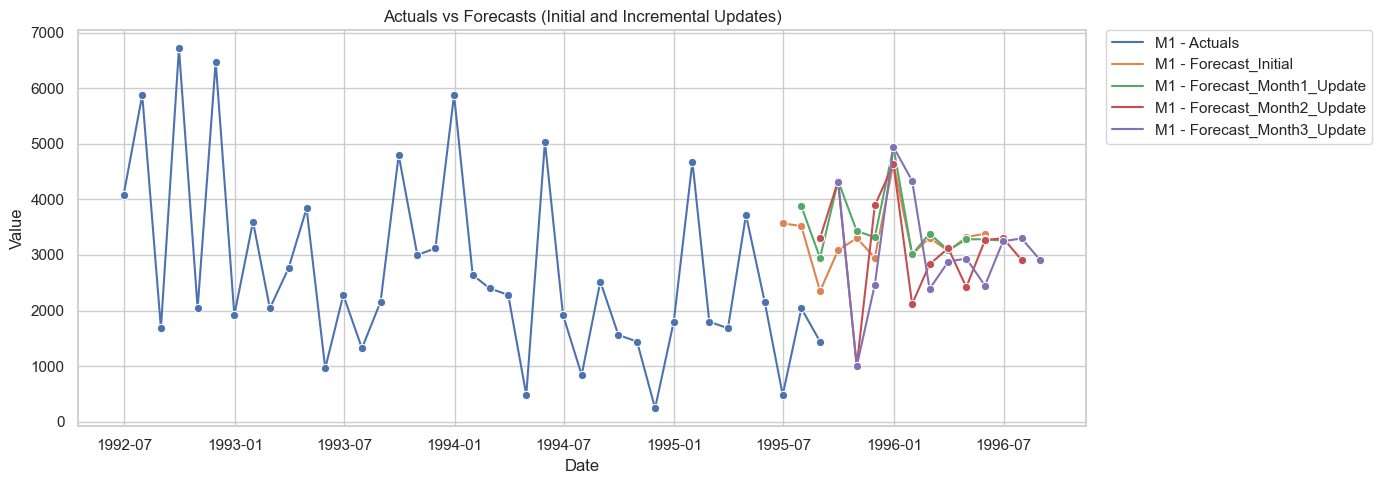

In [9]:

# Prepare prediction DataFrames with descriptive column names ---
predictions_plot = predictions_month_zero.rename(columns={'XGBRegressor': 'Forecast_Initial'})
preds_plot   = predictions_month_one.rename(columns={'XGBRegressor': 'Forecast_Month1_Update'})
preds2_plot  = predictions_month_two.rename(columns={'XGBRegressor': 'Forecast_Month2_Update'})
preds3_plot  = predictions_month_three.rename(columns={'XGBRegressor': 'Forecast_Month3_Update'})

# Melt actuals (train + subsequent actual months) to a common schema ---
def melt_actuals(df, actual_label="Actuals"):
    m = df.melt(id_vars=['unique_id', 'ds'], value_vars=['y'], var_name='Source', value_name='Value')
    m['Source'] = actual_label
    return m

df_train_melted          = melt_actuals(df_train, actual_label="Actuals")
new_data_month_one_melted   = melt_actuals(new_data_month_one, actual_label="Actuals")
new_data_month_two_melted   = melt_actuals(new_data_month_two, actual_label="Actuals")
new_data_month_three_melted = melt_actuals(new_data_month_three, actual_label="Actuals")

# Melt predictions so each forecast becomes rows (unique_id, ds, Source, Value) ---
predictions_melted = predictions_plot.melt(id_vars=['unique_id', 'ds'],
                                           value_vars=['Forecast_Initial'],
                                           var_name='Source', value_name='Value')
preds_melted  = preds_plot.melt(id_vars=['unique_id', 'ds'],
                                value_vars=['Forecast_Month1_Update'],
                                var_name='Source', value_name='Value')
preds2_melted = preds2_plot.melt(id_vars=['unique_id', 'ds'],
                                 value_vars=['Forecast_Month2_Update'],
                                 var_name='Source', value_name='Value')
preds3_melted = preds3_plot.melt(id_vars=['unique_id', 'ds'],
                                 value_vars=['Forecast_Month3_Update'],
                                 var_name='Source', value_name='Value')

# Combine all pieces into a single DataFrame ---
combined_plot_df = pd.concat([
    df_train_melted,
    new_data_month_one_melted,
    new_data_month_two_melted,
    new_data_month_three_melted,
    predictions_melted,
    preds_melted,
    preds2_melted,
    preds3_melted
], ignore_index=True)

# Prepare plotting columns and types ---
# ensure ds is datetime
combined_plot_df['ds'] = pd.to_datetime(combined_plot_df['ds'])
# Construct a combined label (this yields legend entries like "M1 - Actuals", "M1 - Forecast_Initial", ...)
combined_plot_df['label'] = combined_plot_df['unique_id'].astype(str) + " - " + combined_plot_df['Source'].astype(str)

# Sort by date so lines connect in order
combined_plot_df = combined_plot_df.sort_values(['label', 'ds'])

# Optionally keep only a single unique_id if you want (uncomment to focus on one)
# combined_plot_df = combined_plot_df[combined_plot_df['unique_id'] == 'M1']

# Plot using Seaborn (single combined chart) ---
sns.set(style="whitegrid")
plt.figure(figsize=(14, 5))

# lineplot with marker, each label gets its own color (hue)
sns.lineplot(
    data=combined_plot_df,
    x='ds',
    y='Value',
    hue='label',
    marker='o',
    estimator=None,     # do not aggregate; plot raw series
    linewidth=1.5
)

plt.title("Actuals vs Forecasts (Initial and Incremental Updates)")
plt.xlabel("Date")
plt.ylabel("Value")

# Make legend compact and place it on the right
plt.legend(title='', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()


## Conclusion

This work illustrates that incremental forecasting, as operationalized through MLForecast, offers a scalable and resilient paradigm for modern time series modeling. The framework effectively integrates lag-based feature engineering, model persistence, and data-driven updates to accommodate the continuous inflow of new information. Such an approach not only mitigates the computational overhead associated with frequent retraining but also enhances the robustness and maintainability of production forecasting systems, ensuring that predictive performance remains stable under evolving data conditions.

## References

1. Nixtla Team. (2024). *MLForecast: Scalable Machine Learning for Time Series Forecasting.*  
   Available at: [https://nixtlaverse.nixtla.io/mlforecast](https://nixtlaverse.nixtla.io/mlforecast)

2. Makridakis, S., & Hibon, M. (2000). *The M3-Competition: Results, Conclusions and Implications.*  
   *International Journal of Forecasting*, 16(4), 451–476.  
   DOI: [10.1016/S0169-2070(00)00057-1](https://doi.org/10.1016/S0169-2070(00)00057-1)

3. A Practical Guide to Incremental Updates and Transfer Learning for Scalable New-Product Forecasting using MLForecast by Satyajit Chaudhuri. Available at: [Medium](https://medium.com/gitconnected/a-practical-guide-to-incremental-updates-and-transfer-learning-for-scalable-new-product-forecasting-b0c3916ebf78)